In [1]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib
#import swifter
from scipy import stats

%matplotlib inline

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': '________',
    'user': 'student',
    'database': 'simulator_20220920'
}

In [3]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-09-03' and '2022-09-09'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [4]:
df.head(3)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575


# T-test

In [5]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

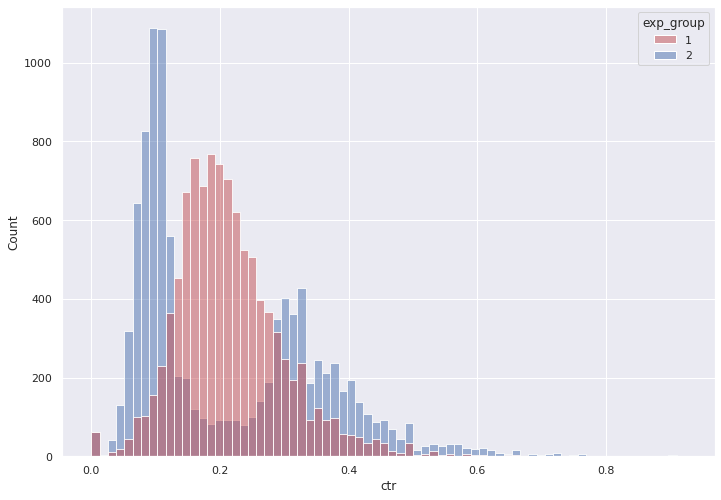

In [6]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

## Вывод:
Сам t-тест показывает, что различия незначительны. Но из графика в тестовой группе мы видим двухгорбое распределение, большой пик CTR ниже среднего контрольной группы и пик, который превосходит то же значение. Пользователи разделились на явные две группы. Доверять результатам т-теста нельзя. 
Первое, что приходит в голову - разделение по платформам. Наш новый алгоритм работает по-разному на ios и андроиде. Может отображение, верстка или сама система алгоритма работает некорректно на одной из них, наши разработчики что-то не учли - отсюда и такая разница в значениях. В то время как нормально работающая система во втором случае отыграла на ура.

In [7]:
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


# Mann-Whitneyu test
Здесь тест показывает более выраженное отличие, поскольку Манн-Уитни работает по гипотезе х1 > х2. А в нашем случае тестовая группа имеет бимодальное распределение.

In [8]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

# Smothed ctr

/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ctr'>

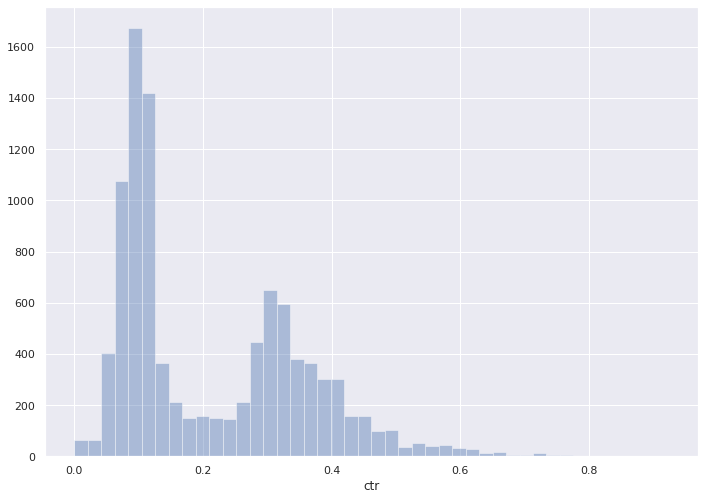

In [9]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

group2 = df[df.exp_group == 2].copy()
sns.distplot(group2.ctr, 
             kde = False)

<AxesSubplot:xlabel='smothed_ctr'>

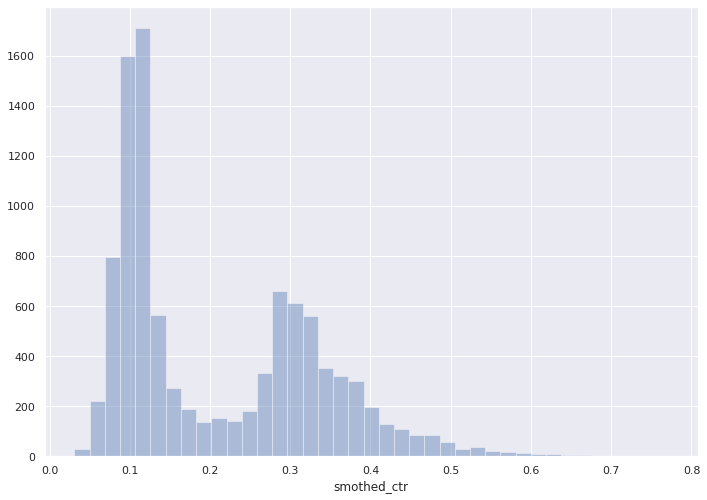

In [10]:
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.distplot(group2.smothed_ctr, 
             kde = False)

Сграживание CTR в подобной тестовой группе (2) не даст нам нужного эффекта, а только исказит выводы. Я бы отказалась от этого варианта

# Бутстреп

In [11]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

<AxesSubplot:ylabel='Count'>

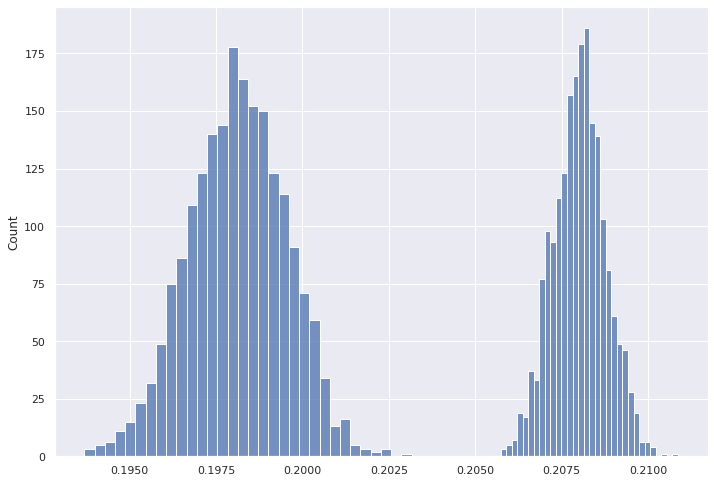

In [12]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

Исходя из общих графиков, будет полезно оценить глобальный CTR с помощью бутстрепа. У нас графики даже не пересекаются, pvalue будет = 0. В одной группе глобальный ctr больше.

Считаем гистограмму разницы. Не пересекает  0. Контрольная группа даже лучше по результату, чем тестовая, хоть и ненамного. Но не будем забывать, что одна мода в тестовой группе показывает результат выше, чем контрольная группа. И нам все еще предстоить понять в чем причина двумодальности. 

<AxesSubplot:ylabel='Count'>

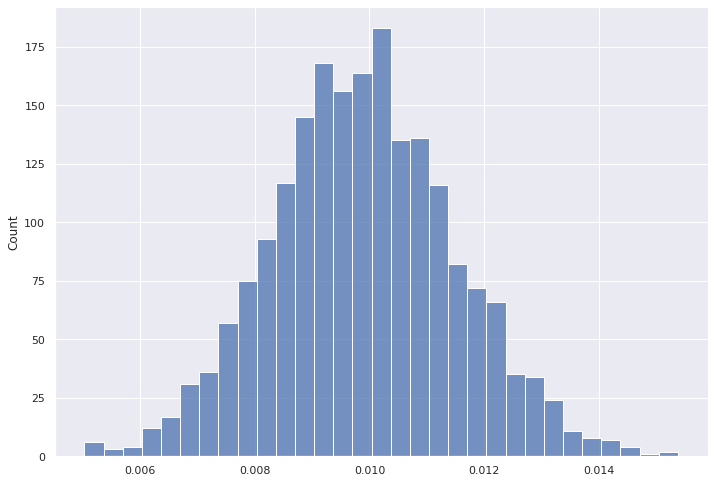

In [13]:
sns.histplot(ctr1 - ctr2) 

# Бакетное преобразование

In [14]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-09-03' and '2022-09-09'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [15]:
#тест Манна-Уитни видит отличие
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

In [16]:
#t-тест
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

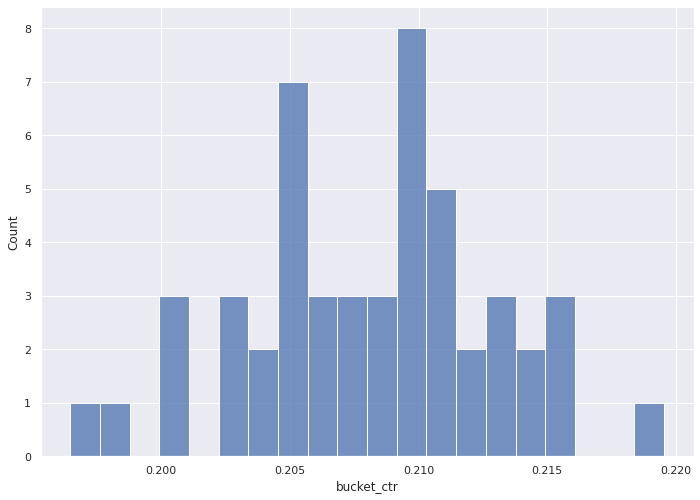

In [17]:
sns.histplot(df[df.exp_group == 1].bucket_ctr, bins = 20)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

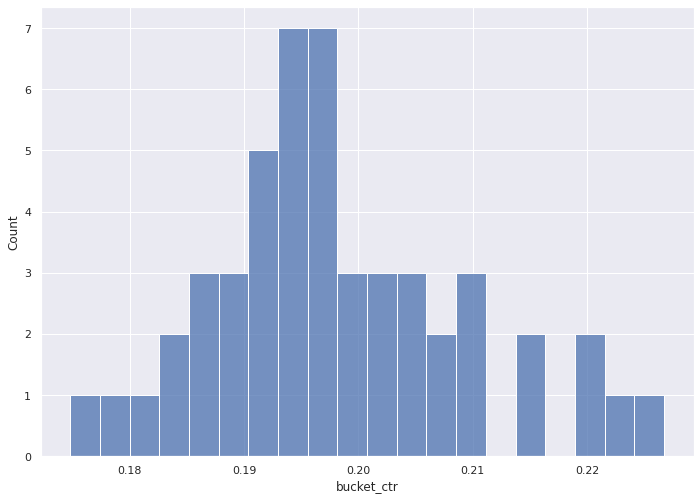

In [18]:
sns.histplot(df[df.exp_group == 2].bucket_ctr, bins = 20)

<AxesSubplot:xlabel='ctr9', ylabel='Count'>

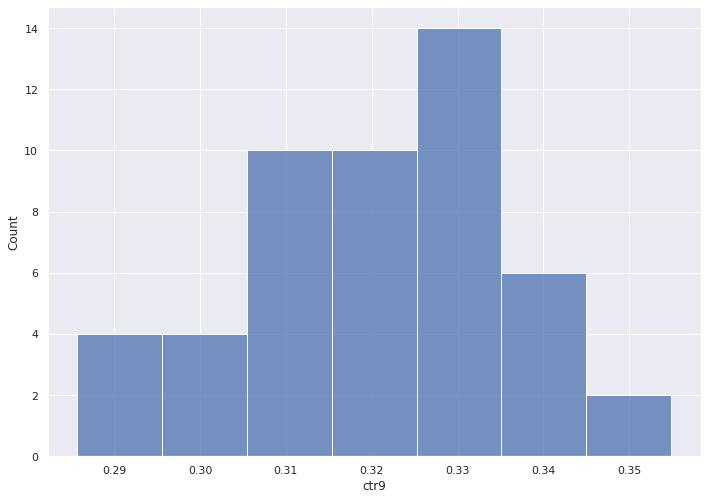

In [19]:
sns.histplot(df[df.exp_group == 1].ctr9)

<AxesSubplot:xlabel='ctr9', ylabel='Count'>

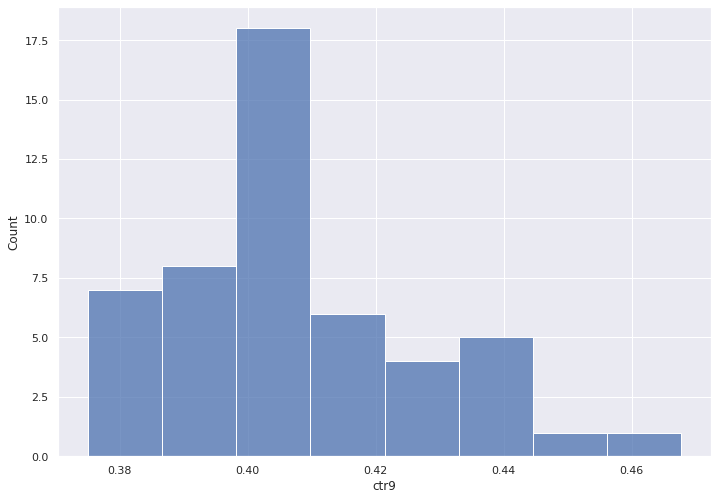

In [20]:
sns.histplot(df[df.exp_group == 2].ctr9)

In [21]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr9, 
                   df[df.exp_group == 2].ctr9, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=6.344839189967265e-18)

Как и в предыдущих тестах : отличие прокрасилось. Нужно анализировать глубже

# Проверим теорию

In [41]:
query = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr,
    os,
    source
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-09-03' and '2022-09-09'
    and exp_group in (1,2)
GROUP BY exp_group, user_id, os, source
"""

df_research = pandahouse.read_clickhouse(query, connection=connection)

In [42]:
df_research.head()

,exp_group,user_id,likes,views,ctr,os,source
0,1,24924,6,52,0.115385,iOS,ads
1,1,10806,11,66,0.166667,Android,ads
2,2,126224,15,148,0.101351,Android,organic
3,1,136449,10,40,0.250000,iOS,organic
4,2,108908,8,20,0.400000,iOS,organic


In [43]:
# сгруппируем по платформе и группам, посчитаем кол-во юзеров
df_research.groupby(['os', 'exp_group'], as_index=False) \
            .agg({'user_id' : 'count'})

,os,exp_group,user_id
0,Android,1,6532
1,Android,2,6409
2,iOS,1,3547
3,iOS,2,3543


Владельцев андроида в 2 раза больше, что довольно странно. Группы попадают под несоответствие правилам статистической эквивалентности в АА тестировании. Они должны отличаться друг от друга только нашим воздействием в рамках теста. Поведение пользователей на различных устройствах может различаться и влиять на наш тест.

In [44]:
# сгруппируем по платформе и группам, посчитаем среднее ctr
df_research.groupby(['os', 'exp_group'], as_index=False) \
            .agg({'ctr' : 'mean'})

,os,exp_group,ctr
0,Android,1,0.215665
1,Android,2,0.216102
2,iOS,1,0.215492
3,iOS,2,0.211376


Ничего криминального. Еще интересно было бы посмотреть медиану

In [45]:
# сгруппируем по платформе и группам, посчитаем медиану
df_research.groupby(['os', 'exp_group'], as_index=False) \
            .agg({'ctr' : 'median'})

,os,exp_group,ctr
0,Android,1,0.203704
1,Android,2,0.145729
2,iOS,1,0.202614
3,iOS,2,0.133803


В задании сказано, что идеального ответа нет. Может данные не приспособлены к подобному анализу, но в целом это теоретически возможно на практике. Как итог, раскатывать этот АВ тест на всех пользователей, очевидно, нельзя. До тех пор пока мы на найдем причину двухгорбого распределения и не проведем митап с ml департаментом. АВ тест следует переделать, снова оценить корректность выборок на АА тесте, которые мы не делали в этом задании, и покопаться в данных.